In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import cluster
from sklearn.metrics import silhouette_score
import statsmodels.api as sm
from statsmodels.formula.api import ols

## Get and View Data

In [2]:
data = pd.read_csv('house_sales.csv')
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


Describe the dataset. 

In [3]:
data.shape

(21613, 21)

There are 21,613 rows and 21 columns. 

In [4]:
data.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,20479.000000,20545.000000,20503.000000,2.056900e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.372821,2.113507,2081.073697,1.517982e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930711,0.768913,915.043176,4.148617e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.500000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1920.000000,7.620000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.070800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,12050.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


Check for nulls. 

data.isna().sum()

bedrooms, bathrooms, sqft_living, and sqft_lot contain nulls. We'll deal with these later. 

Now let's remove the columns that we will not use to model price: 
- id: The unique id of each house is not relevant for modeling sale price. 
- grade: This score is derived from many of the other variables in the dataset, so any information it provides about home price is redundant. 

In [5]:
data.drop(['id', 'grade'], axis=1, inplace=True)

## Handle Outliers

Let's start with the date column.

In [6]:
columns_with_outliers = set() 

In [7]:
type(data.date[0])

str

The values in the date column are strings. We should convert them to dates. 

In [8]:
data['date'] = pd.DatetimeIndex(data.date)

In [9]:
#data['date'] = data.apply(lambda row: pd.to_datetime(row.date), axis=1)
#data['date']

In [10]:
#data['date'] = data['date'].dt.date
#data['date']

In [11]:
data.date.min(), data.date.max()

(Timestamp('2014-05-02 00:00:00'), Timestamp('2015-05-27 00:00:00'))

All of the dates are within 2014 and 2015, as expected. Let's move on to price. 

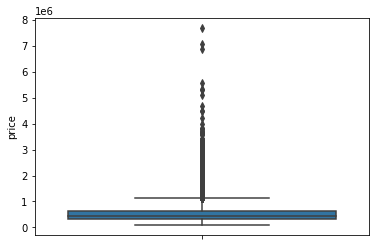

In [12]:
sns.boxplot(data=data, y='price')
plt.show()

There are many price outliers that right-skew the distribution. Let's add it to our set of columns with outliers. And look at bedrooms. 

In [13]:
columns_with_outliers.add('price')

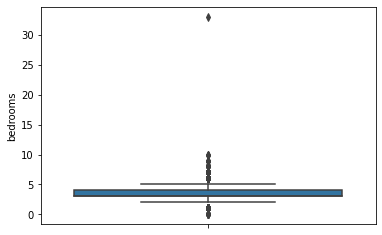

In [14]:
sns.boxplot(data=data, y='bedrooms')
plt.show()

There are bedrooms outliers so let's add it to our set and look at bathrooms. 

In [15]:
columns_with_outliers.add('bedrooms')

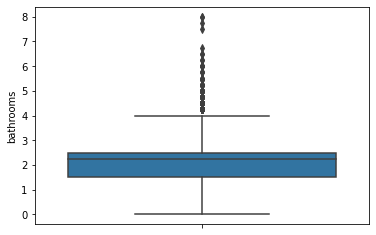

In [16]:
sns.boxplot(data=data, y='bathrooms')
plt.show()

There are bathrooms outliers so let's add it to our set and look at sqft_living.

In [17]:
columns_with_outliers.add('bathrooms')

Let's now take a look at sqft_living. 

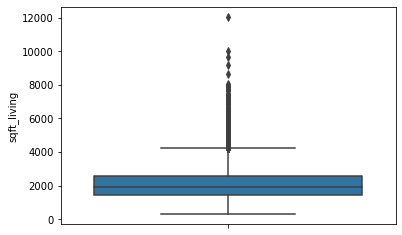

In [18]:
sns.boxplot(data=data, y='sqft_living')
plt.show()

There are sqft_living outliers so let's add it to our set and look at sqft_lot. 

In [19]:
columns_with_outliers.add('sqft_living')

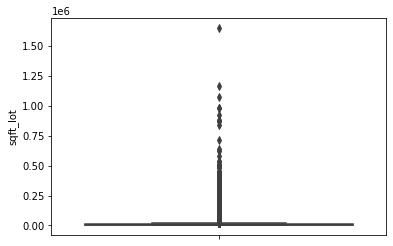

In [20]:
sns.boxplot(data=data, y='sqft_lot')
plt.show()

This distribution is extremely right-skewed with many outliers. Let's add it to our set and look at floors.

In [21]:
columns_with_outliers.add('sqft_lot')

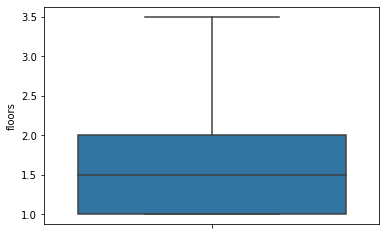

In [22]:
sns.boxplot(data=data, y='floors')
plt.show()

There are no floors outliers so let's move on. waterfront is a binary variable with a max of 1 so no outliers there. view is supposed to be a binary variable but the max is 4, so it must have some data errors. 

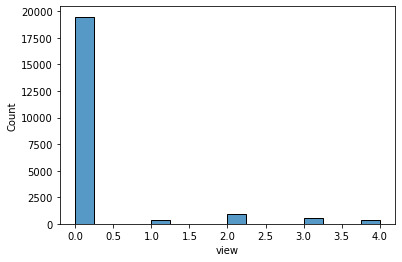

In [23]:
sns.histplot(data.view)
plt.show()

Some view values are 2, 3, and 4. Let's add this to our set but make sure we treat it differently when it comes time to actually identify outliers. 

In [24]:
columns_with_outliers.add('view')

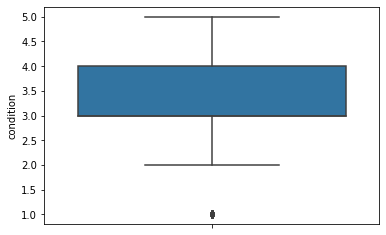

In [25]:
sns.boxplot(data=data, y='condition')
plt.show()

Condition has outliers so let's add it to our set and look at sqft_above.

In [26]:
columns_with_outliers.add('condition')

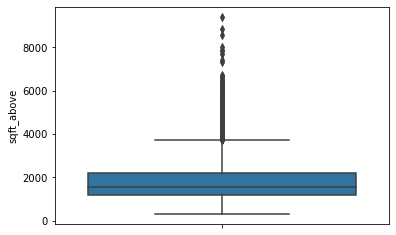

In [27]:
sns.boxplot(data=data, y='sqft_above')
plt.show()

sqft_above has outliers so let's add it to our set and look at sqft_basement.

In [28]:
columns_with_outliers.add('sqft_above')

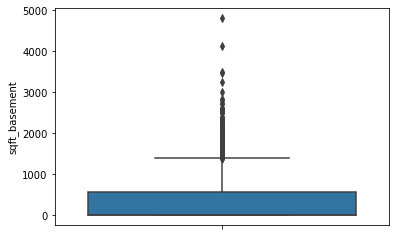

In [29]:
sns.boxplot(data=data, y='sqft_basement')
plt.show()

sqft_basement has outliers so let's add it to our set and look at yr_built.

In [30]:
columns_with_outliers.add('sqft_basement')

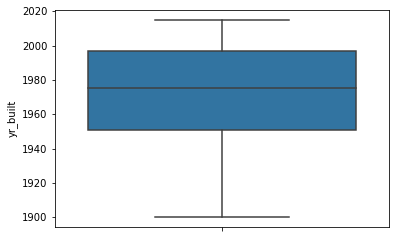

In [31]:
sns.boxplot(data=data, y='yr_built')
plt.show()

No yr_built outliers. Let's look at yr_renovated. Homes that have not been renovated have a value of 0. Let's replace these with nulls so they don't skew the distribution. 

In [32]:
data.yr_renovated.replace(0, np.nan, inplace=True)

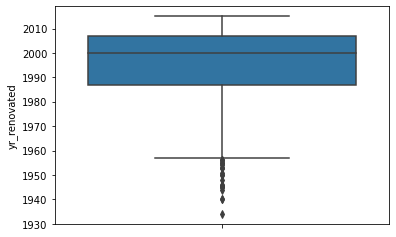

In [33]:
sns.boxplot(data=data, y='yr_renovated')
plt.show()

There are some outliers so let's add this to our set and look at zipcode. 

In [34]:
columns_with_outliers.add('yr_renovated')

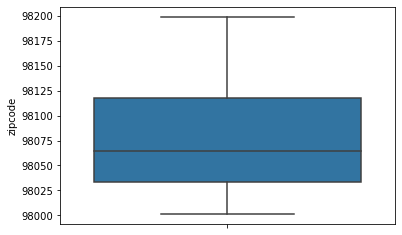

In [35]:
sns.boxplot(data=data, y='zipcode')
plt.show()

No zipcode outliers so let's move on to sqft_living15. 

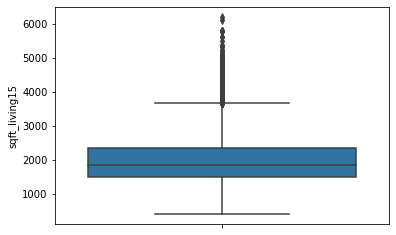

In [36]:
sns.boxplot(data=data, y='sqft_living15')
plt.show()

It has outliers so let's add it to our set and look at sqft_lot15. 

In [37]:
columns_with_outliers.add('sqft_living15')

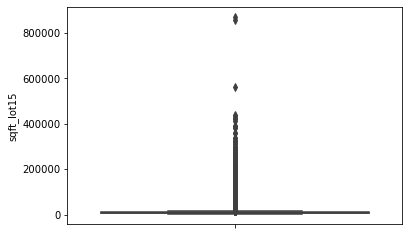

In [38]:
sns.boxplot(data=data, y='sqft_lot15')
plt.show()

There are some very extreme outliers so let's add this column to our set as well. 

In [39]:
columns_with_outliers.add('sqft_lot15')

In [40]:
columns_with_outliers

{'bathrooms',
 'bedrooms',
 'condition',
 'price',
 'sqft_above',
 'sqft_basement',
 'sqft_living',
 'sqft_living15',
 'sqft_lot',
 'sqft_lot15',
 'view',
 'yr_renovated'}

In [41]:
def get_outliers(column):
    if column == 'view': # special logic to handle the view column 
        return data[data.view > 1]
    q1 = data[column].quantile(.25) 
    q3 = data[column].quantile(.75)
    iqr = q3 - q1
    return data[(data[column] < q1 - 1.5 * iqr) | (data[column] > q3 + 1.5 * iqr)]

In [42]:
def consolidate_outliers(columns): 
    outlier_dfs = [] # list to store the dataframe with each column's outliers 
    for c in columns: # for each column 
        df = get_outliers(c) # get its outliers as a dataframe
        outlier_dfs.append(df) # add that dataframe to the list 
    return pd.concat(outlier_dfs).drop_duplicates() # vertically combine the dataframes and drop duplicate rows

In [43]:
outliers = consolidate_outliers(columns_with_outliers)
outliers.shape

(5242, 19)

Our consolidated, deduped dataframe of outliers from all columns has 4,348 houses. Let's remove them from our dataset. 

In [44]:
data = data.merge(
    outliers,
    how='outer',
    indicator=True
).query('_merge == "left_only"').drop('_merge', axis=1)
data.shape

(16371, 19)

We have 16,371 rows left after removing the outliers. 

## Impute Missing Data

In [45]:
data.isna().sum()

date                 0
price                0
bedrooms           879
bathrooms          774
sqft_living        845
sqft_lot           850
floors               0
waterfront           0
view                 0
condition            0
sqft_above           0
sqft_basement        0
yr_built             0
yr_renovated     15861
zipcode              0
lat                  0
long                 0
sqft_living15        0
sqft_lot15           0
dtype: int64

bedrooms, bathrooms, sqft_living, sqft_lot, and yr_renovated have missing values. yr_renovated only has missing values because we replaced the 0's with nulls when looking for outliers. Let's change them back to 0's. 

In [46]:
data.yr_renovated.fillna(0, inplace=True)
data.yr_renovated.isna().sum()

0

In [47]:
data.sqft_lot.corr(data.sqft_lot15)

0.8791175047808103

sqft_lot and sqft_lot15 are also quite strongly positively correlated, with a coefficient of 0.88

Create df of rows with null sqft_living and sqft_lot to use later.

In [48]:
nullsqft_living = data['sqft_living'].isnull()
null_living = pd.DataFrame(data['sqft_living15'][nullsqft_living])

nullsqft_lot = data['sqft_lot'].isnull()
null_lot = pd.DataFrame(data['sqft_lot15'][nullsqft_lot])

Create a data set of data without outliers and where sqft_living and sqft_lot are non-empty Use this set for regression analysis

In [49]:
filtereddata = data.dropna(subset = ['sqft_living', 'sqft_lot'])
filtereddata.shape[0]

14717

In [50]:
data.median(numeric_only=True)

price            415000.0000
bedrooms              3.0000
bathrooms             2.0000
sqft_living        1760.0000
sqft_lot           7091.0000
floors                1.0000
waterfront            0.0000
view                  0.0000
condition             3.0000
sqft_above         1440.0000
sqft_basement         0.0000
yr_built           1973.0000
yr_renovated          0.0000
zipcode           98072.0000
lat                  47.5693
long               -122.2620
sqft_living15      1714.0000
sqft_lot15         7200.0000
dtype: float64

Sqft_lot based on sqft_lot15

In [51]:
model = ols("sqft_lot ~ sqft_lot15", data=filtereddata).fit()
modelsummary = model.summary()
print(modelsummary)

                            OLS Regression Results                            
Dep. Variable:               sqft_lot   R-squared:                       0.772
Model:                            OLS   Adj. R-squared:                  0.772
Method:                 Least Squares   F-statistic:                 4.981e+04
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:36:12   Log-Likelihood:            -1.2962e+05
No. Observations:               14717   AIC:                         2.592e+05
Df Residuals:                   14715   BIC:                         2.593e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    202.8950     33.551      6.047      0.0

In [52]:
data['sqft_lot_pred'] = model.predict(data.sqft_lot15) # use the model to predict sqft_lot from sqft_lot15

In [53]:
data['sqft_lot'] = data.apply(
    lambda row:
        row.sqft_lot_pred
    if np.isnan(row.sqft_lot) else row.sqft_lot, axis=1)
data.drop(columns=['sqft_lot_pred'], inplace=True) # we no longer need this column now that we've imputed sqft_lot

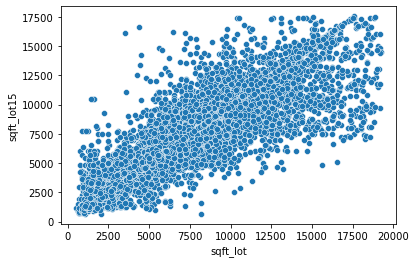

0.8848872284499838

In [54]:
sns.scatterplot(data=data, x='sqft_lot', y='sqft_lot15')
plt.show()
data.sqft_lot.corr(data.sqft_lot15)

sqft_living based on sqft_living15

In [55]:
model = ols("sqft_living ~ sqft_living15", data=filtereddata).fit()
modelsummary = model.summary()
print(modelsummary)

                            OLS Regression Results                            
Dep. Variable:            sqft_living   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.537
Method:                 Least Squares   F-statistic:                 1.707e+04
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:36:14   Log-Likelihood:            -1.1045e+05
No. Observations:               14717   AIC:                         2.209e+05
Df Residuals:                   14715   BIC:                         2.209e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       229.0443     12.866     17.802

In [56]:
data['sqft_living_pred'] = model.predict(data.sqft_living15) # use the model to predict sqft_living from sqft_living15

In [57]:
data['sqft_living'] = data.apply(
    lambda row:
        row.sqft_living_pred
    if np.isnan(row.sqft_living) else row.sqft_living, axis=1)
data.drop(columns=['sqft_living_pred'], inplace=True) # we no longer need this column now that we've imputed sqft_living

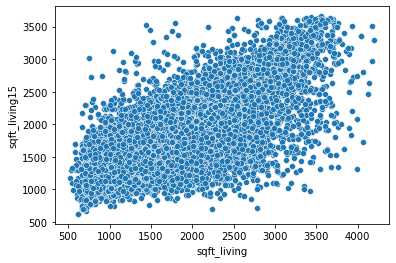

0.7431137994860139

In [58]:
sns.scatterplot(data=data, x='sqft_living', y='sqft_living15')
plt.show()
data.sqft_living.corr(data.sqft_living15)

In [59]:
data.isna().sum()

date               0
price              0
bedrooms         879
bathrooms        774
sqft_living        0
sqft_lot           0
floors             0
waterfront         0
view               0
condition          0
sqft_above         0
sqft_basement      0
yr_built           0
yr_renovated       0
zipcode            0
lat                0
long               0
sqft_living15      0
sqft_lot15         0
dtype: int64

There are no null sqft_living or sqft_lot records anymore.

In [60]:
data.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,1.637100e+04,15492.000000,15597.000000,16371.000000,16371.000000,16371.000000,16371.0,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000,16371.000000
mean,4.491966e+05,3.269042,1.987882,1842.644268,7080.798993,1.475933,0.0,0.013805,3.408222,1609.964022,232.107935,1970.745709,62.238409,98080.142875,47.559102,-122.226055,1816.442001,6962.028648
std,1.911349e+05,0.778422,0.662792,638.499581,3383.591776,0.544872,0.0,0.116684,0.642177,631.197579,356.910843,29.762532,347.107390,53.469244,0.140109,0.132301,533.871488,3028.393000
min,8.200000e+04,2.000000,0.500000,520.000000,520.000000,1.000000,0.0,0.000000,2.000000,480.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.472000,620.000000,651.000000
25%,3.007615e+05,3.000000,1.500000,1362.500000,4760.000000,1.000000,0.0,0.000000,3.000000,1140.000000,0.000000,1951.000000,0.000000,98033.000000,47.464800,-122.334000,1430.000000,4840.000000
50%,4.150000e+05,3.000000,2.000000,1760.000000,7100.000000,1.000000,0.0,0.000000,3.000000,1440.000000,0.000000,1973.000000,0.000000,98072.000000,47.569300,-122.262000,1714.000000,7200.000000
75%,5.600000e+05,4.000000,2.500000,2240.000000,9008.819696,2.000000,0.0,0.000000,4.000000,1950.000000,460.000000,1998.000000,0.000000,98118.000000,47.681900,-122.149000,2120.000000,8775.000000
max,1.127000e+06,5.000000,4.000000,4200.000000,19210.000000,3.500000,0.0,1.000000,5.000000,3740.000000,1400.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.319000,3660.000000,17550.000000


Create dataset without missing values for bedrooms and bathrooms.

In [61]:
filtereddata2 = data.dropna(subset = ['bedrooms', 'bathrooms'])
filtereddata2.shape[0]

14765

In [62]:
filtereddata2.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
price,1.000000,0.264865,0.390239,0.556092,-0.061737,0.263282,NaN,0.102514,0.046400,0.458317,0.201706,0.012478,0.094108,0.000665,0.481087,0.032513,0.487261,-0.068176
bedrooms,0.264865,1.000000,0.463805,0.605727,0.194640,0.156451,NaN,0.005751,0.011267,0.490833,0.241758,0.174712,0.011291,-0.179570,-0.069668,0.170787,0.411566,0.183176
bathrooms,0.390239,0.463805,1.000000,0.678946,-0.066379,0.530414,NaN,0.022759,-0.163632,0.607657,0.168991,0.576047,0.019696,-0.227157,-0.032935,0.259178,0.522404,-0.070660
sqft_living,0.556092,0.605727,0.678946,1.000000,0.181743,0.349934,NaN,0.066160,-0.089267,0.838240,0.304535,0.357136,0.021154,-0.219731,-0.005204,0.279716,0.744108,0.169699
sqft_lot,-0.061737,0.194640,-0.066379,0.181743,1.000000,-0.371441,NaN,0.037470,0.124798,0.145376,0.066975,-0.069373,-0.009061,-0.253811,-0.138734,0.243933,0.220659,0.884326
floors,0.263282,0.156451,0.530414,0.349934,-0.371441,1.000000,NaN,-0.027384,-0.289885,0.539747,-0.314718,0.531614,-0.010480,-0.069132,0.017700,0.141433,0.283987,-0.379367
waterfront,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
view,0.102514,0.005751,0.022759,0.066160,0.037470,-0.027384,NaN,1.000000,0.013565,0.011407,0.096725,-0.042233,0.021309,0.061174,0.009343,-0.066366,0.086626,0.047444
condition,0.046400,0.011267,-0.163632,-0.089267,0.124798,-0.289885,NaN,0.013565,1.000000,-0.194961,0.184078,-0.382339,-0.062457,0.000279,0.004276,-0.103765,-0.142411,0.127492
sqft_above,0.458317,0.490833,0.607657,0.838240,0.145376,0.539747,NaN,0.011407,-0.194961,1.000000,-0.240984,0.472146,-0.008816,-0.291072,-0.076793,0.390702,0.722430,0.134378


Bathrooms and bedrooms do not have a strong correlation with any of the other variables so we will use median imputation.

In [63]:
data['bedrooms'] = data['bedrooms'].fillna(data['bedrooms'].median())

In [64]:
data['bathrooms'] = data['bathrooms'].fillna(data['bathrooms'].median())

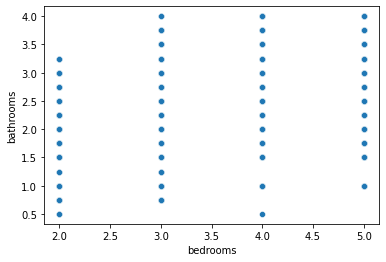

In [65]:
sns.scatterplot(data=data, x='bedrooms', y='bathrooms')
plt.show()

In [66]:
data.isna().sum()

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [67]:
data.median(numeric_only=True)

price            415000.0000
bedrooms              3.0000
bathrooms             2.0000
sqft_living        1760.0000
sqft_lot           7100.0000
floors                1.0000
waterfront            0.0000
view                  0.0000
condition             3.0000
sqft_above         1440.0000
sqft_basement         0.0000
yr_built           1973.0000
yr_renovated          0.0000
zipcode           98072.0000
lat                  47.5693
long               -122.2620
sqft_living15      1714.0000
sqft_lot15         7200.0000
dtype: float64

## Engineer Features

### Location

zipcode is a categorical variable with 70 unique values. We'll need to dummify it if we're going to include it in our model. But 69 binary variables is a lot, so first we should check whether zipcode is at all informative of price. 

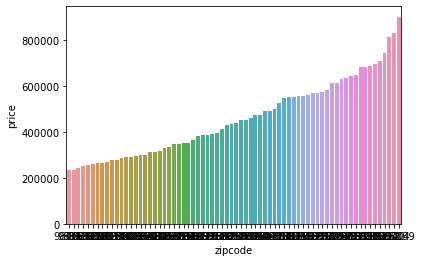

In [68]:
mean_price_by_zipcode = data.groupby(['zipcode'])[['price']].mean().reset_index()
sns.barplot(
    data=mean_price_by_zipcode, 
    x='zipcode', 
    y='price', 
    order=mean_price_by_zipcode.sort_values('price').zipcode
)
plt.show()

It looks like there's quite a lot of variance in price across zipcodes, so zipcode could be helpful in predicting a home's sell price. 

Let's try clustering homes on latitude and longitude to see if we can capture location information with fewer categories. Let's start by plotting lat and long and coloring by price. 

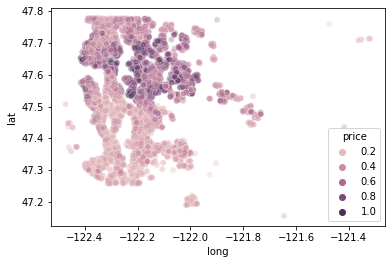

In [69]:
sns.scatterplot(data=data, x='long', y='lat', hue='price', alpha=0.3)
plt.show()

It looks like houses in the north tend to be pricier than those in the south. Let's try clustering on geo coordinates using the K Means algorithm. 

We don't know which number of clusters is optimal so we'll have to iteratively test out different values. 

In [70]:
coords = data[['long', 'lat']].values # store lat and long as a numpy array
k_clusters = np.arange(2, 21) # we'll be testing 2 to 20 clusters 
sse_scores = [] 
silhouette_scores = []
for k in k_clusters: # for each number of clusters 
    kmeans = cluster.KMeans(n_clusters=k, random_state=5) # instantiate a K Means with that many clusters
    kmeans.fit(coords) # fit it to the coordinates 
    sse_scores.append(kmeans.inertia_) # record its Sum of Squared Errors 
    silhouette_scores.append(silhouette_score(coords, kmeans.labels_)) # record its Silhouette Score 

In [71]:
# store the scores for each k calculated above in a dataframe for easy plotting 
kmeans_scores = pd.DataFrame({
    'k': k_clusters,
    'SSE': sse_scores,
    'Silhouette Coefficient': silhouette_scores
})

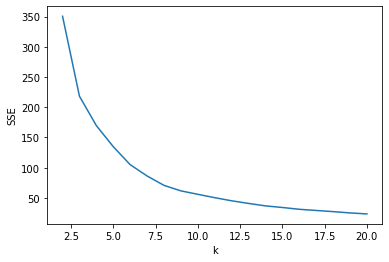

In [72]:
sns.lineplot(data=kmeans_scores, x='k', y='SSE')
plt.show()

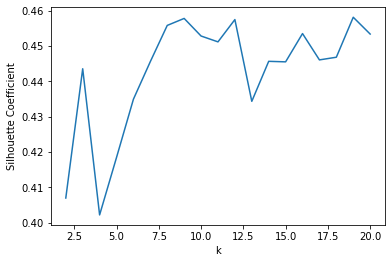

In [73]:
sns.lineplot(data=kmeans_scores, x='k', y='Silhouette Coefficient')
plt.show()

Using the Elbow Method we can see that the SSE curve's inflection is around k=8. We also see that the Silhouette Coefficient's maximum occurs at k=8. These metrics' corroboration gives us confidence to move forward with 8 clusters. 

In [74]:
kmeans = cluster.KMeans(n_clusters=8, random_state=5).fit(coords)
data['cluster'] = kmeans.labels_ # store the homes' cluster labels as a column in our dataset 

Let's plot our geo clusters and see how they look. 

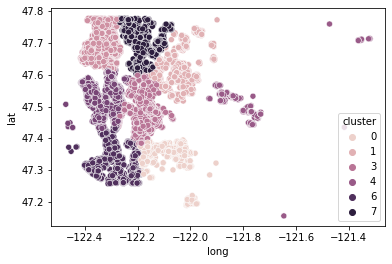

In [75]:
sns.scatterplot(data=data, x='long', y='lat', hue='cluster')
plt.show()

Looks pretty good! But do they correlate with price? Let's regress price on our clusters to find out. To do that we first need to dummify our clusters. 

In [76]:
cluster_dummies = pd.get_dummies(
    data.cluster, 
    drop_first=True, 
    prefix='cluster'
)
cluster_dummies.head()

,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,0,0,0,0,1,0,0
1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1
3,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0


In [77]:
exog = sm.add_constant(cluster_dummies)
endog = data.price
lm = sm.OLS(endog, exog).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.285
Model:                            OLS   Adj. R-squared:                  0.284
Method:                 Least Squares   F-statistic:                     930.6
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:40:18   Log-Likelihood:            -2.1957e+05
No. Observations:               16371   AIC:                         4.392e+05
Df Residuals:                   16363   BIC:                         4.392e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const           3e+05   4411.888     67.998      0.0

Our geo clusters alone explain 28.4% of variance in home price. Not bad! Let's add them to the rest of our data and give them more intuitive names. 

In [78]:
data = pd.concat([data, cluster_dummies], axis=1)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,cluster,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
0,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,...,1340,5650,5,0,0,0,0,1,0,0
1,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,...,1690,7639,2,0,1,0,0,0,0,0
2,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,...,2720,8062,7,0,0,0,0,0,0,1
3,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,...,1360,5000,5,0,0,0,0,1,0,0
4,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,...,1800,7503,1,1,0,0,0,0,0,0


In [79]:
data.rename(
    columns={
        'cluster_1': 'northeast',
        'cluster_2': 'northwest',
        'cluster_3': 'southeast',
        'cluster_4': 'east_central',
        'cluster_5': 'southwest',
        'cluster_6': 'inland',
        'cluster_7': 'north_central'
    },
    inplace=True
)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_living15,sqft_lot15,cluster,northeast,northwest,southeast,east_central,southwest,inland,north_central
0,2014-10-13,221900.0,3.0,1.00,1180.0,5650.0,1.0,0,0,3,...,1340,5650,5,0,0,0,0,1,0,0
1,2014-12-09,538000.0,3.0,2.25,2570.0,7242.0,2.0,0,0,3,...,1690,7639,2,0,1,0,0,0,0,0
2,2015-02-25,180000.0,2.0,1.00,770.0,10000.0,1.0,0,0,3,...,2720,8062,7,0,0,0,0,0,0,1
3,2014-12-09,604000.0,4.0,3.00,1960.0,5000.0,1.0,0,0,5,...,1360,5000,5,0,0,0,0,1,0,0
4,2015-02-18,510000.0,3.0,2.00,1680.0,8080.0,1.0,0,0,3,...,1800,7503,1,1,0,0,0,0,0,0


In [80]:
data.drop(columns=['zipcode', 'lat', 'long', 'cluster'], inplace=True)

### Age

We should express yr_built and yr_renovated as ages to make them more interpretable. 

In [81]:
data['age'] = data.date.dt.year - data.yr_built
data.age.describe()

count    16371.000000
mean        43.579134
std         29.766278
min         -1.000000
25%         16.000000
50%         41.000000
75%         64.000000
max        115.000000
Name: age, dtype: float64

It looks like there are some houses with an inferred age of -1. Let's inspect them.

In [82]:
data[data.age == -1][['date', 'yr_built']]

,date,yr_built
1763,2014-06-25,2015
7526,2014-12-31,2015
8039,2014-06-24,2015
14489,2014-08-26,2015
17098,2014-06-17,2015
19805,2014-08-01,2015
20852,2014-07-09,2015
20963,2014-07-31,2015
21262,2014-11-25,2015


It looks like these are likely just data entry errors. Let's change their age to 0. 

In [83]:
data.age.replace(-1, 0, inplace=True)
data.age.describe()

count    16371.000000
mean        43.579684
std         29.765464
min          0.000000
25%         16.000000
50%         41.000000
75%         64.000000
max        115.000000
Name: age, dtype: float64

Let's now derive renovation age. 

In [84]:
data['was_renovated'] = data.apply(
    lambda row: 1 if row.yr_renovated != 0 else 0,
    axis=1
)
data.was_renovated

0        0
1        1
2        0
3        0
4        0
        ..
21608    0
21609    0
21610    0
21611    0
21612    0
Name: was_renovated, Length: 16371, dtype: int64

In [85]:
data.drop(columns=['yr_built', 'yr_renovated'], inplace=True)
data.columns

Index(['date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'sqft_above',
       'sqft_basement', 'sqft_living15', 'sqft_lot15', 'northeast',
       'northwest', 'southeast', 'east_central', 'southwest', 'inland',
       'north_central', 'age', 'was_renovated'],
      dtype='object')

### Season

In [86]:
def get_season(date):
    if date.month in (12, 1, 2):
        return 'winter'
    if date.month in (3, 4, 5): 
        return 'spring'
    if date.month in (6, 7, 8):
        return 'summer'
    if date.month in (9, 10, 11):
        return 'fall'

In [87]:
data['season'] = data.apply(lambda row: get_season(row.date), axis=1)
data['season'].describe()

count      16371
unique         4
top       spring
freq        4910
Name: season, dtype: object

In [88]:
season_dummies = pd.get_dummies(data.season, drop_first=True)
season_dummies.describe()

,spring,summer,winter
count,16371.000000,16371.000000,16371.000000
mean,0.299921,0.293201,0.172500
std,0.458237,0.455244,0.377826
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000


In [89]:
data = pd.concat([data, season_dummies], axis = 1)
data.drop(columns=['date', 'season'], inplace=True)
data.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement',
       'sqft_living15', 'sqft_lot15', 'northeast', 'northwest', 'southeast',
       'east_central', 'southwest', 'inland', 'north_central', 'age',
       'was_renovated', 'spring', 'summer', 'winter'],
      dtype='object')

## Predicting Price

In [90]:
X = data.drop('price', axis=1) 
Y = data['price']
X  = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.648
Method:                 Least Squares   F-statistic:                     1310.
Date:                Thu, 15 Apr 2021   Prob (F-statistic):               0.00
Time:                        21:40:21   Log-Likelihood:            -2.1376e+05
No. Observations:               16371   AIC:                         4.276e+05
Df Residuals:                   16347   BIC:                         4.277e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.527e+05   9159.636    -27.593

Check for multicollinearity:

In [92]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    
print(vif)

/home/aubrey/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables         VIF
0           const  106.768289
1        bedrooms    1.634016
2       bathrooms    2.728891
3     sqft_living   41.009317
4        sqft_lot    4.823330
5          floors    2.711535
6      waterfront         NaN
7            view    1.032247
8       condition    1.292406
9      sqft_above   39.989623
10  sqft_basement   13.315633
11  sqft_living15    2.725953
12     sqft_lot15    4.911151
13      northeast    2.166733
14      northwest    3.853851
15      southeast    2.352968
16   east_central    1.267862
17      southwest    3.208221
18         inland    2.116009
19  north_central    2.201611
20            age    2.639904
21  was_renovated    1.117877
22         spring    1.599247
23         summer    1.596283
24         winter    1.440704


Keep statistically significant variables and remove sqft_above because it has a high VIF suggesting multicollinearity.

In [104]:
X2 = data.drop(['price', 'sqft_above', 'bedrooms', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'winter'], axis=1) 
Y = data['price']
X2  = sm.add_constant(X2)
model = sm.OLS(Y, X2).fit()
predictions = model.predict(X2) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.618
Model:                            OLS   Adj. R-squared:                  0.617
Method:                 Least Squares   F-statistic:                     1555.
Date:                Fri, 16 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:10:04   Log-Likelihood:            -2.1444e+05
No. Observations:               16371   AIC:                         4.289e+05
Df Residuals:                   16353   BIC:                         4.291e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -2.051e+05   8572.314    -23.927

In [105]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["variables"] = X2.columns
vif["VIF"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
    
print(vif)

/home/aubrey/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


        variables        VIF
0           const  86.059385
1       bathrooms   2.514728
2     sqft_living   2.060148
3        sqft_lot   1.597243
4          floors   1.977446
5      waterfront        NaN
6            view   1.017318
7       condition   1.269171
8       northeast   2.148913
9       northwest   3.660948
10      southeast   2.337264
11   east_central   1.264791
12      southwest   3.057034
13         inland   2.098306
14  north_central   2.173040
15            age   2.607039
16  was_renovated   1.111706
17         spring   1.218155
18         summer   1.221080


Removing sqft_above seems to have improved VIF of other variables.

In [107]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
x = data.drop(['price', 'price'],axis=1) 
y = data['price']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)



knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(x_train, y_train)
y_pred = knn_model.predict(x_test)


print("KNN Test set predictions: {}".format(knn_model.predict(x_test)))


# Model Accuracy, how often is the classifier correct?
print("Accuracy:", knn_model.score(x_test, y_test))

KNN Test set predictions: [353790. 713500. 429845. ... 477748. 288460. 667225.]
Accuracy: 0.430403967018398


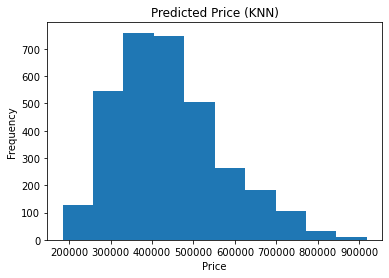

In [108]:
knn_pred = knn_model.predict(x_test)
plt.hist(knn_pred) 
plt.title("Predicted Price (KNN)") 
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

In [109]:
from sklearn import metrics
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
import math

x = data.drop(['price', 'sqft_above'],axis=1) 
y = data['price']

#array of possible alpha values for CV later
alphas = 10**np.linspace(10,-2,100)*0.5

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)

ridge = Ridge(alpha=.05, normalize = True)
ridge.fit(x_train, y_train)
pred_ridge = ridge.predict(x_test)


print("Ridge Training set score: {:.2f}".format(ridge.score(x_train, y_train)))
print("Ridge Test set score: {:.2f}".format(ridge.score(x_test, y_test)))
print("R^2:",metrics.r2_score(y_test, pred_ridge))
print("MSE:", metrics.mean_squared_error(y_test, pred_ridge))

Ridge Training set score: 0.63
Ridge Test set score: 0.65
R^2: 0.6525632585143899
MSE: 12968211391.947123


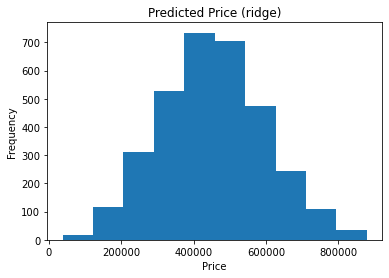

In [110]:
plt.hist(pred_ridge) 
plt.title("Predicted Price (ridge)") 
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()